In [12]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Load dataset
df = pd.read_csv('./data/owid-covid-data.csv')

# Load dataset from URL but slower than local file
# Note: The URL may change over time, so ensure you have the correct link
# df = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/refs/heads/master/public/data/owid-covid-data.csv')

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Select relevant columns to reduce memory usage
relevant_columns = [
    'iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
    'total_deaths', 'new_deaths', 'total_vaccinations', 'people_vaccinated',
    'population'
]
df = df[relevant_columns]

# Explore structure
print("Columns:", df.columns)
print("\nFirst 5 rows:\n", df.head())
print("\nMissing values:\n", df.isnull().sum())

Columns: Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'total_deaths', 'new_deaths', 'total_vaccinations', 'people_vaccinated',
       'population'],
      dtype='object')

First 5 rows:
   iso_code continent     location       date  total_cases  new_cases  \
0      AFG      Asia  Afghanistan 2020-01-05          0.0        0.0   
1      AFG      Asia  Afghanistan 2020-01-06          0.0        0.0   
2      AFG      Asia  Afghanistan 2020-01-07          0.0        0.0   
3      AFG      Asia  Afghanistan 2020-01-08          0.0        0.0   
4      AFG      Asia  Afghanistan 2020-01-09          0.0        0.0   

   total_deaths  new_deaths  total_vaccinations  people_vaccinated  population  
0           0.0         0.0                 NaN                NaN    41128772  
1           0.0         0.0                 NaN                NaN    41128772  
2           0.0         0.0                 NaN                NaN    41128772  
3           0.

In [2]:
# Filter for specific countries
countries = ['Kenya', 'United States', 'India']
df_filtered = df[df['location'].isin(countries)].copy()  # Use .copy() to avoid warning

# Drop rows with missing critical values
df_filtered = df_filtered.dropna(subset=['date', 'total_cases'])

# Fill missing values for key columns
df_filtered['total_vaccinations'] = df_filtered['total_vaccinations'].fillna(0)
df_filtered['total_deaths'] = df_filtered['total_deaths'].fillna(0)
df_filtered['people_vaccinated'] = df_filtered['people_vaccinated'].fillna(0)

# Verify cleaning
print("Missing values after cleaning:\n", df_filtered.isnull().sum())

Missing values after cleaning:
 iso_code                0
continent               0
location                0
date                    0
total_cases             0
new_cases             442
total_deaths            0
new_deaths              0
total_vaccinations      0
people_vaccinated       0
population              0
dtype: int64


### Exploratory Data Analysis
This section analyzes trends in COVID-19 cases and deaths for Kenya, USA, and India.

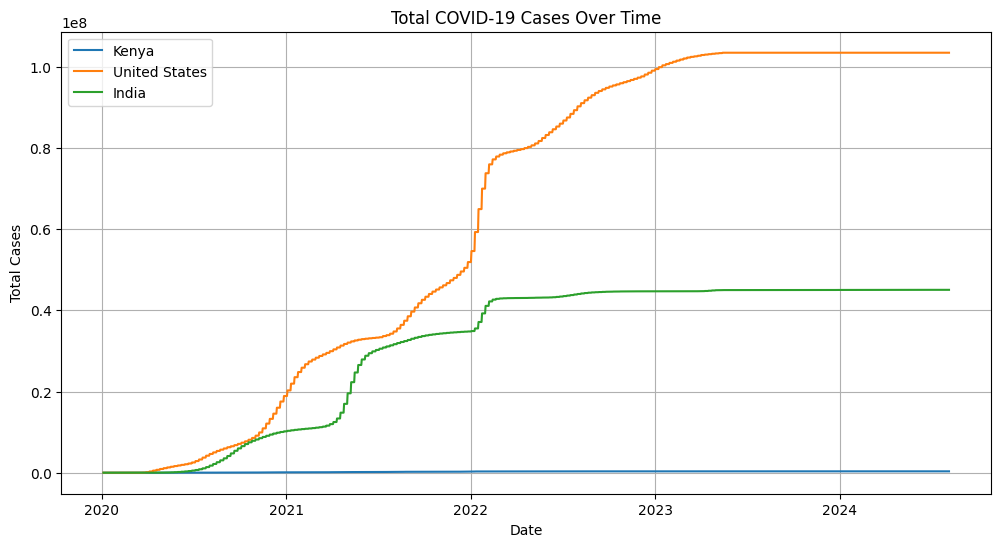

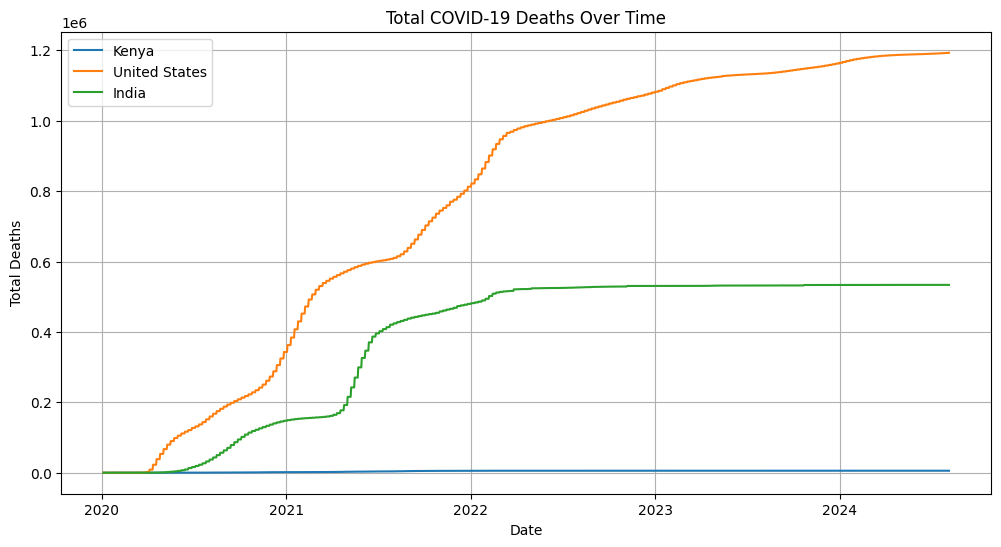

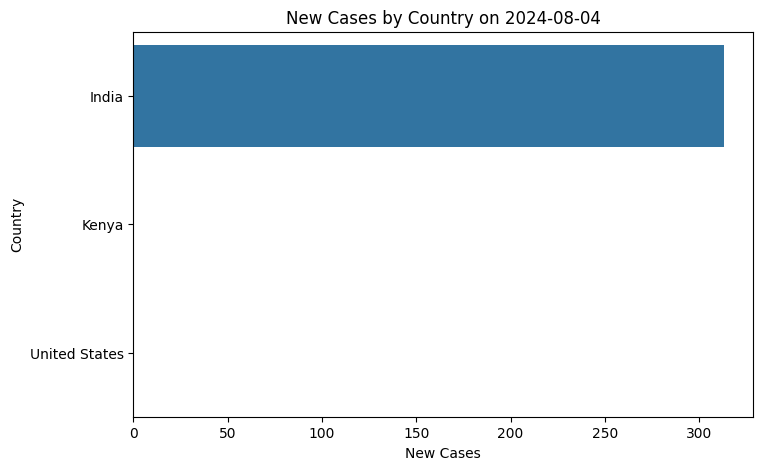

Death Rates (latest date):
              location  death_rate
175222          India    0.011847
196995          Kenya    0.016533
405124  United States    0.011535


In [4]:
# Line plot: Total cases over time
plt.figure(figsize=(12, 6))
for country in countries:
    country_data = df_filtered[df_filtered['location'] == country]
    plt.plot(country_data['date'], country_data['total_cases'], label=country)
plt.title('Total COVID-19 Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Total Cases')
plt.legend()
plt.grid(True)
plt.show()

# Line plot: Total deaths over time
plt.figure(figsize=(12, 6))
for country in countries:
    country_data = df_filtered[df_filtered['location'] == country]
    plt.plot(country_data['date'], country_data['total_deaths'], label=country)
plt.title('Total COVID-19 Deaths Over Time')
plt.xlabel('Date')
plt.ylabel('Total Deaths')
plt.legend()
plt.grid(True)
plt.show()

# Bar plot: New cases on latest date
latest_date = df_filtered['date'].max()
latest_data = df_filtered[df_filtered['date'] == latest_date].copy()
plt.figure(figsize=(8, 5))
sns.barplot(x='new_cases', y='location', data=latest_data)
plt.title(f'New Cases by Country on {latest_date.date()}')
plt.xlabel('New Cases')
plt.ylabel('Country')
plt.show()

# Calculate death rate for latest data
latest_data['death_rate'] = latest_data['total_deaths'] / latest_data['total_cases'].replace(0, 1)  # Avoid division by zero
print("Death Rates (latest date):\n", latest_data[['location', 'death_rate']])

### Vaccination Progress
This section visualizes vaccination trends and coverage for the selected countries.

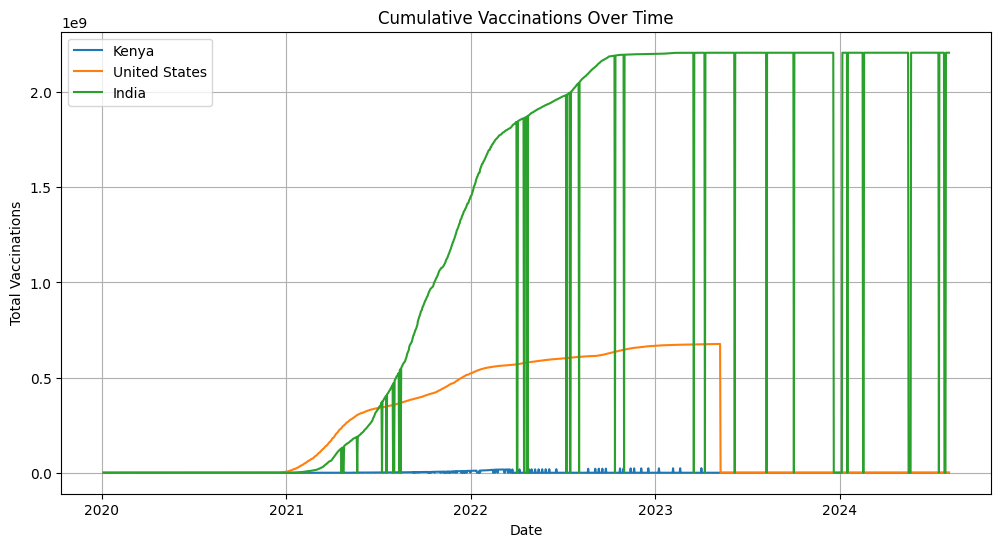

Vaccination Data (latest date):
              location  people_vaccinated  population  vaccinated_percent
175222          India       1.027439e+09  1417173120           72.499181
196995          Kenya       0.000000e+00    54027484            0.000000
405124  United States       0.000000e+00   338289856            0.000000


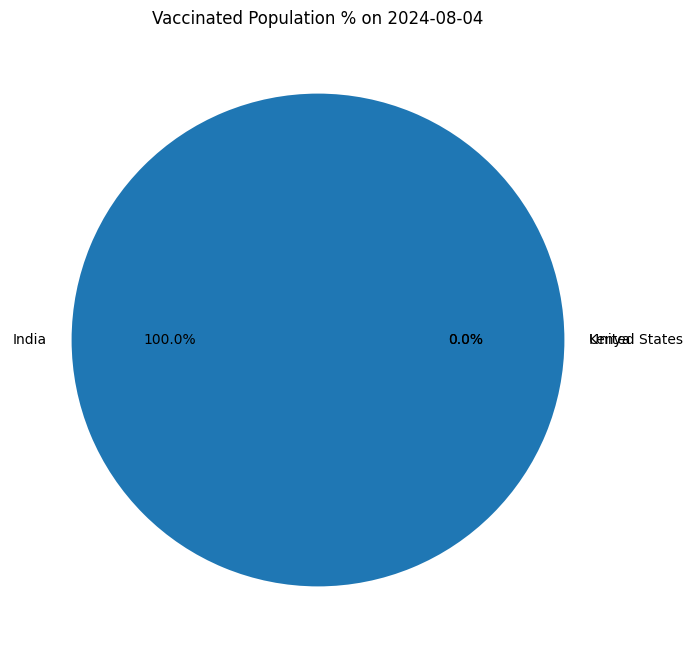

In [5]:
# Line plot: Cumulative vaccinations over time
plt.figure(figsize=(12, 6))
for country in countries:
    country_data = df_filtered[df_filtered['location'] == country]
    plt.plot(country_data['date'], country_data['total_vaccinations'], label=country)
plt.title('Cumulative Vaccinations Over Time')
plt.xlabel('Date')
plt.ylabel('Total Vaccinations')
plt.legend()
plt.grid(True)
plt.show()

# Pie chart: Vaccinated population % (latest date)
latest_data = df_filtered[df_filtered['date'] == latest_date].copy()
latest_data['vaccinated_percent'] = (latest_data['people_vaccinated'] / latest_data['population']) * 100
latest_data['vaccinated_percent'] = latest_data['vaccinated_percent'].fillna(0)

# Validate vaccination data
print("Vaccination Data (latest date):\n", latest_data[['location', 'people_vaccinated', 'population', 'vaccinated_percent']])

plt.figure(figsize=(8, 8))
plt.pie(latest_data['vaccinated_percent'], labels=latest_data['location'], autopct='%1.1f%%')
plt.title(f'Vaccinated Population % on {latest_date.date()}')
plt.show()

### Global Choropleth Map
This section visualizes total COVID-19 cases by country on the latest date with available data.

In [8]:
import plotly.express as px

# Step 1: Check the date range of the dataset
print("Dataset date range:", df['date'].min(), "to", df['date'].max())

# Step 2: Inspect data for the latest date
latest_date = df['date'].max()
latest_data = df[df['date'] == latest_date][['iso_code', 'total_cases', 'location', 'continent']]
print("Data for latest date (before cleaning):\n", latest_data)
print("Missing values for latest date:\n", latest_data.isnull().sum())

# Step 3: Find the most recent date with valid total_cases and iso_code
valid_data = df[df['total_cases'].notnull() & df['iso_code'].notnull() & df['continent'].notnull()]
if valid_data.empty:
    print("No valid data available for choropleth map. Check dataset for missing values.")
else:
    latest_valid_date = valid_data['date'].max()
    choropleth_data = valid_data[valid_data['date'] == latest_valid_date][['iso_code', 'total_cases', 'location']]
    print("Choropleth Data (latest valid date ", latest_valid_date.date(), "):\n", choropleth_data)

    # Step 4: Plot choropleth map
    if not choropleth_data.empty:
        fig = px.choropleth(
            choropleth_data,
            locations='iso_code',
            color='total_cases',
            hover_name='location',
            color_continuous_scale='Reds',
            title=f'Global COVID-19 Cases on {latest_valid_date.date()}'
        )
        fig.show()
    else:
        print("Choropleth data is empty. No map to display.")

Dataset date range: 2020-01-01 00:00:00 to 2024-08-14 00:00:00
Data for latest date (before cleaning):
         iso_code  total_cases                       location continent
21775   OWID_ASI          NaN                           Asia       NaN
120252  OWID_EUR          NaN                         Europe       NaN
121602  OWID_EUN          NaN            European Union (27)       NaN
165198  OWID_HIC          NaN          High-income countries       NaN
217093       LTU          NaN                      Lithuania    Europe
230301       MYS          NaN                       Malaysia      Asia
408137  OWID_UMC          NaN  Upper-middle-income countries       NaN
424412  OWID_WRL          NaN                          World       NaN
Missing values for latest date:
 iso_code       0
total_cases    8
location       0
continent      6
dtype: int64
Choropleth Data (latest valid date  2024-08-04 ):
        iso_code  total_cases           location
1673        AFG     235214.0        Afghanis